# Slice thickness and partial volume effect

In [2]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib.gridspec import GridSpec

# Set LaTeX to render with Computer Modern font
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern Roman']
plt.rcParams['text.usetex'] = True  # Enable LaTeX rendering



In [3]:
folder_data = '/Users/hannerokstad/Desktop/Project_NTNU/Data/BILLY_PHANTOM_24_10_10-11_10_40-DST-1_3_12_2_1107_5_2_0_79123/JOHANNA_LAURAPHD_20241010_111131_730000/'

# Folder for all different images
folder_TE = 'Slice_thickness_TE/'

In [4]:
# Function for cropping image
def crop_image(image, x1, x2, y1, y2):
    '''
    Function for cropping an image.
    
    Input:
    image: 2D numpy array
    x1, x2, y1, y2 (int): Coordinates for cropping
    
    Output:
    Cropped image
    '''
    return image[x1:x2, y1:y2]

In [5]:
def load_images(delta_z, num, x1, x2, y1, y2):
    '''
    Load images from the different echo times and crop them to the desired size.

    Input:
    delta_z (list, str): slice thickness for each echo time
    num (list, int): filenumber of the echo time
    x1, x2, y1, y2 (int): Cropping the image
    '''

    # List for storing all images
    images = [] # Uncropped first echo
    images_cropped = [] # First echo
    images_cropped_e9 = [] # Final echo

    # Directory to each echo time image
    for i in range(len(delta_z)):
        dir_z = 'MGE_9TE_' + delta_z[i] + 'MM_250HZ_00' + str(num[i]) + '/9TE_' + delta_z[i] + 'MM_250HZ_00' + str(num[i]) + '_e1.nii.gz'
        dir_z_e9 = 'MGE_9TE_' + delta_z[i] + 'MM_250HZ_00' + str(num[i]) + '/9TE_' + delta_z[i] + 'MM_250HZ_00' + str(num[i]) + '_e9.nii.gz'
        data = nib.load(folder_data + folder_TE + dir_z)
        img = np.rot90(data.get_fdata(), 1) # Image stack is rotated when given

        data_e9 = nib.load(folder_data + folder_TE + dir_z_e9)
        img_e9 = np.rot90(data_e9.get_fdata(), 1) # Image stack is rotated when given

        images.append(img)

        # Also save a cropped version
        img_cropped = crop_image(img, x1, x2, y1, y2)
        images_cropped.append(img_cropped)
        img_cropped_e9 = crop_image(img_e9, x1, x2, y1, y2)
        images_cropped_e9.append(img_cropped_e9)
    
    return images, images_cropped, images_cropped_e9

In [6]:
# Slice thickness
delta_z = ['1P5', '3', '6'] # mm

# Corresponding numbers from filenames
num = [26, 22, 24]

images, images_cropped, images_cropped_e9 = load_images(delta_z, num, 150, 340, 125, 375)

In [7]:
# Get the reference image
ref_img_cropped = images_cropped[0]
ref_img_cropped_e9 = images_cropped_e9[0]

## Difference map

In [15]:
def plot_difference_map(img_idx):
    '''
    Function for plotting the difference map between the first and last echo for a given slice index
     
    Input:
    img_idx (int): Slice index
    '''

    # Get slice for echo 1 and echo 9
    slice_e1 = [img[:, :, img_idx] for img in images_cropped]
    slice_e9 = [img[:, :, img_idx] for img in images_cropped_e9]

    mask = np.load(f'../ROI/slice_thickness/idx{img_idx}_reduced.npy') # Using the reduces ROI to avoid signal vairation from surface coil sensitivity profile in full ROI of the spinal canal
    roi = mask > 0

    # Save SNR values
    SNR_e1_all = []
    SNR_e9_all = []

    # Values for colorbar
    min_val = np.min([(np.min(slice_e1[i]), np.min(slice_e9[i])) for i in range(3)])
    max_val = np.max([(np.max(slice_e1[i]), np.max(slice_e9[i])) for i in range(3)])

    # Save difference images in list for equal scaling (max, min found during iteration-loop)
    diff = []

    # Create a GridSpec with 2 rows and 4 columns (last colum for colorbar)
    fig = plt.figure(figsize=(15, 10))
    gs = GridSpec(2, 4, width_ratios=[1, 1, 1, 0.05])

    axs = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(3)]
    cax1 = fig.add_subplot(gs[0, 3])
    cax2 = fig.add_subplot(gs[1, 3])

    # Title second row left side of plot
    fig.text(0.11, 0.3, r'TE$_9$ - TE$_1$', va='center', rotation='vertical', fontsize=16)

    # Second row: normalized, ROI diff e9-e1 all slice thicknesses full image
    # For all thicknesses, mask the ROI
    for i in range(len(delta_z)):

        # Use copy to avoid changing the original image
        e1 = slice_e1[i].copy()
        e9 = slice_e9[i].copy()

        # Normalize the images to make them comparable between slice thicknesses
        max_val_full = np.nanmax([np.nanmax(e1), np.nanmax(e9)])
        e1_norm_full = e1 / max_val_full
        e9_norm_full = e9 / max_val_full

        # Get the difference e9 - e1
        diff.append(e9_norm_full - e1_norm_full)
    
        # Set all areas expect ROI to nan
        e1[~roi] = np.nan
        e9[~roi] = np.nan

        # SNR calculation of ROI
        SNR_e1 = np.nanmean(e1) / np.nanstd(e1)
        SNR_e9 = np.nanmean(e9) / np.nanstd(e9)
        SNR_e1_all.append(SNR_e1)
        SNR_e9_all.append(SNR_e9)

    # Values for colorbar difference images
    min_val_diff = np.min([np.min(diff[i]) for i in range(3)])
    max_val_diff = np.max([np.max(diff[i]) for i in range(3)])

    # First row: e1 for all slice thicknesses
    for i in range(len(delta_z)):
        img = axs[i].imshow(slice_e1[i], cmap='gray', vmin=min_val, vmax=max_val)
        # add text to the image
        axs[i].text(10, 200, f'SNR ROI: {SNR_e1_all[i]:.2f}', color='black', fontsize=16)
        axs[i].axis('off')
        if i == 0:
            axs[i].set_title(r'$\Delta z$ = 1.5mm', fontsize = 16)
        else:
            axs[i].set_title(r'$\Delta z$ = ' + delta_z[i] +'mm', fontsize = 16)
        img1 = axs[i + 3].imshow(diff[i], cmap='gray', vmin=min_val_diff, vmax=max_val_diff)
        axs[i + 3].axis('off')

    cbar = fig.colorbar(img, cax=cax1, fraction=0.021, pad=0.04)
    cbar1 = fig.colorbar(img1, cax=cax2, fraction=0.021, pad=0.04)

    cbar.set_label('A.U.', rotation=0, labelpad = 15)
    cbar1.set_label('A.U.', rotation=0, labelpad=15)
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    plt.show()

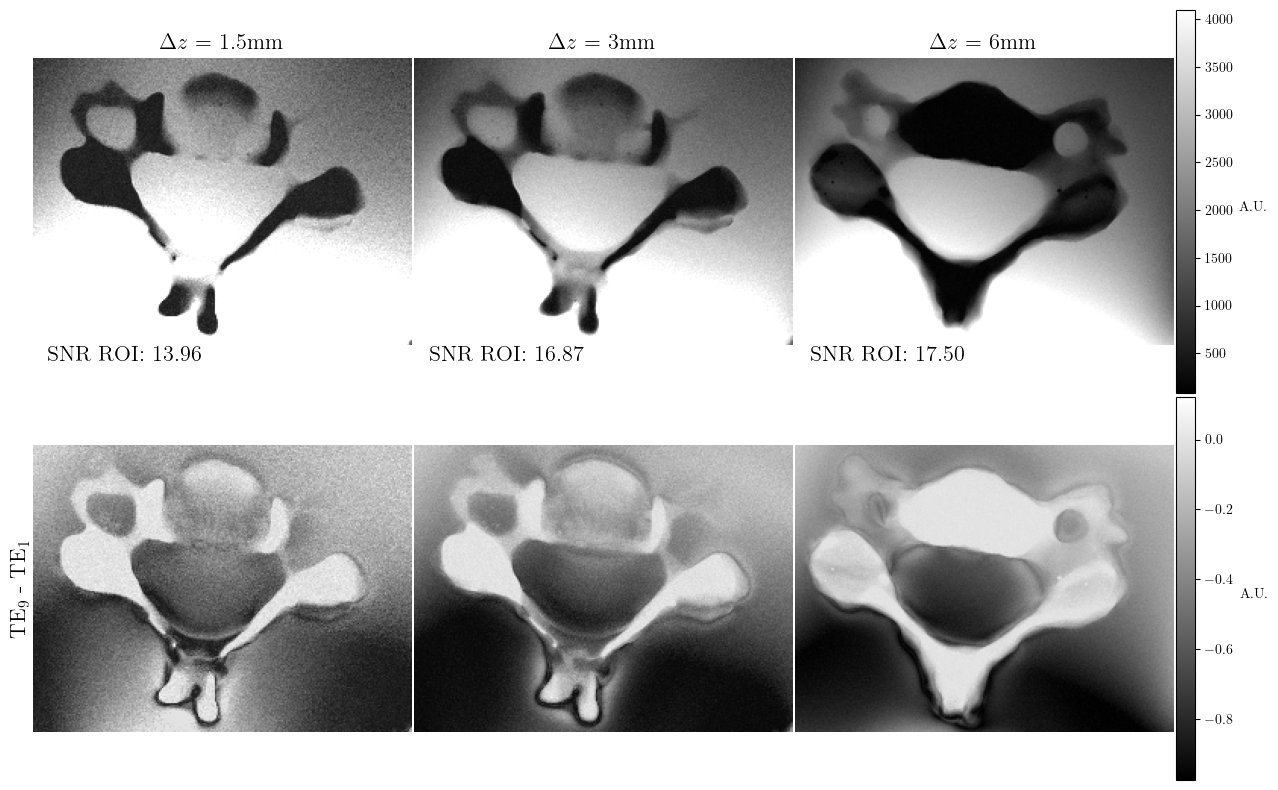

In [16]:
img_idx = 4
plot_difference_map(img_idx)

## Intensity ratio

In [ ]:
def plot_intensity_ratio(img_idx):   
    '''
    Plot the intensity ratio between the final and first echo for all slice thicknesses, as well as the defined ROI on the refernece image of 1.5mm slice thickness.

    Input:
    img_idx (int): Index of the image to plot
    '''

    # Create a GridSpec with 2 rows and 4 columns (last colum for colorbar)
    fig = plt.figure(figsize=(15, 6))
    gs = GridSpec(1, 5, width_ratios=[1, 1, 1, 1, 0.05])

    axs = [fig.add_subplot(gs[i, j]) for i in range(1) for j in range(4)]
    cax = fig.add_subplot(gs[0, 4])

    # Initial values for colorbar
    vmin = np.inf
    vmax = -np.inf

    # To store all intensity ratios
    dI_all = []

    # Get slice for echo 1 and echo 9
    slice_e1 = [img[:, :, img_idx] for img in images_cropped]
    slice_e9 = [img[:, :, img_idx] for img in images_cropped_e9]

    mask = np.load(f'../ROI/slice_thickness/idx{img_idx}_reduced.npy') # Using the reduces ROI to avoid signal vairation from surface coil sensitivity profile in full ROI of the spinal canal
    roi = mask > 0

    # Values for colorbar
    min_val = np.min([(np.min(slice_e1[i]), np.min(slice_e9[i])) for i in range(3)])
    max_val = np.max([(np.max(slice_e1[i]), np.max(slice_e9[i])) for i in range(3)])

    # Plot the image with overlaying ROI
    img_roi = slice_e1[1].copy()
    img_roi[roi] = np.nan

    cmap = mpl.colormaps.get_cmap('gray')
    cmap.set_bad('red')

    # Plot an image with the ROI
    im = axs[0].imshow(img_roi, cmap=cmap, vmax = max_val, vmin = min_val)
    axs[0].axis('off')

    for i in range(len(delta_z)):
        e1 = slice_e1[i].copy()
        e9 = slice_e9[i].copy()

        # All areas except ROI set to NaN
        e1[~roi] = np.nan
        e9[~roi] = np.nan

        # Ratio ROI
        dI = e9 / e1

        # Update min and max values for colorbar
        vmin = min(vmin, np.nanmin(dI))
        vmax = max(vmax, np.nanmax(dI))

        dI_all.append(dI)

    # Second pass to plot the images
    for k in range(len(delta_z)):
        im = axs[k+1].imshow(dI_all[k][50:150, 50:175], cmap='gray', vmin=vmin, vmax=vmax) # Crop the images to better see the ROIs
        axs[k+1].axis('off')
        if k == 0:
            axs[k+1].set_title(r'$\Delta z$ = 1.5mm', fontsize = 16)
        else:
            axs[k+1].set_title(r'$\Delta z$ = ' + delta_z[k] +'mm', fontsize = 16)

    cbar = fig.colorbar(im, cax=cax, fraction=0.021, pad=0.04)
    cbar.set_label(r'Intensity Ratio $\frac{e9}{e1}$', rotation=270, labelpad=20, fontsize=16)

    plt.tight_layout()
    plt.show()

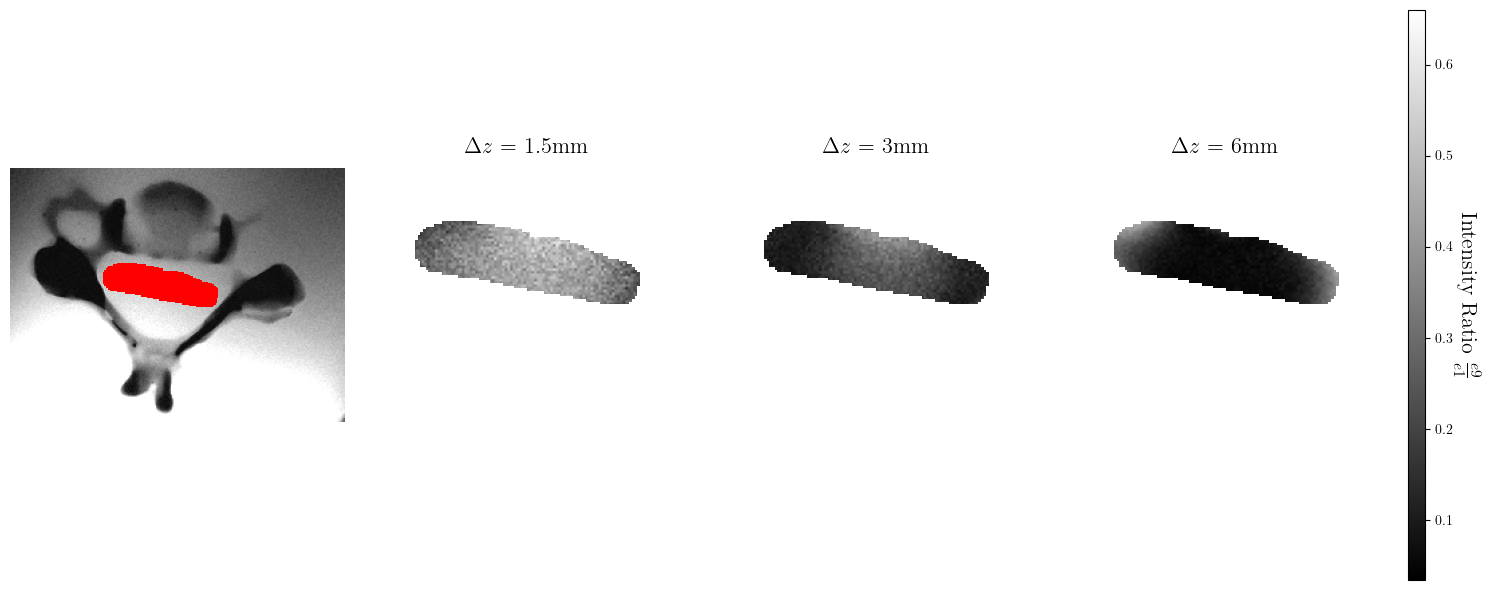

In [19]:
img_idx = 4
plot_intensity_ratio(img_idx)

# Appendix

In [22]:
def plot_white_halo(img_idx):
    '''
    Plot the first and final echo for the largest slice thickness to see the effect of increased TE and partial volume effects

    Input:
    img_idx (int): Index of the image to plot
    '''
    #  Create a GridSpec with 1 row and 3 columns
    fig = plt.figure(figsize=(15, 6))
    gs = GridSpec(1, 3, width_ratios=[1, 1, 0.05])

    axs = [fig.add_subplot(gs[i, j]) for i in range(1) for j in range(2)]

    slice_e1 = [img[:, :, img_idx] for img in images_cropped]
    slice_e9 = [img[:, :, img_idx] for img in images_cropped_e9]

    slice = [slice_e1, slice_e9]

    min_val = np.min([np.min(slice[i][2]) for i in range(2)])
    max_val = np.max([np.max(slice[i][2]) for i in range(2)])

    TE = [4.55, 38.63]

    for i in range(len(TE)):
        axs[i].set_title('TE = ' + str(TE[i]) + 'ms', fontsize = 16)
        img = axs[i].imshow(slice[i][2], cmap='gray', vmin=min_val, vmax=max_val)
        axs[i].axis('off')

    cax = fig.add_subplot(gs[0, 2])
    cbar = fig.colorbar(img, cax = cax, orientation='vertical', shrink = 0.5)
    cbar.set_label('A.U.', rotation=0, labelpad=15)

    plt.subplots_adjust(wspace=0.1, hspace=0.01)

    plt.show()

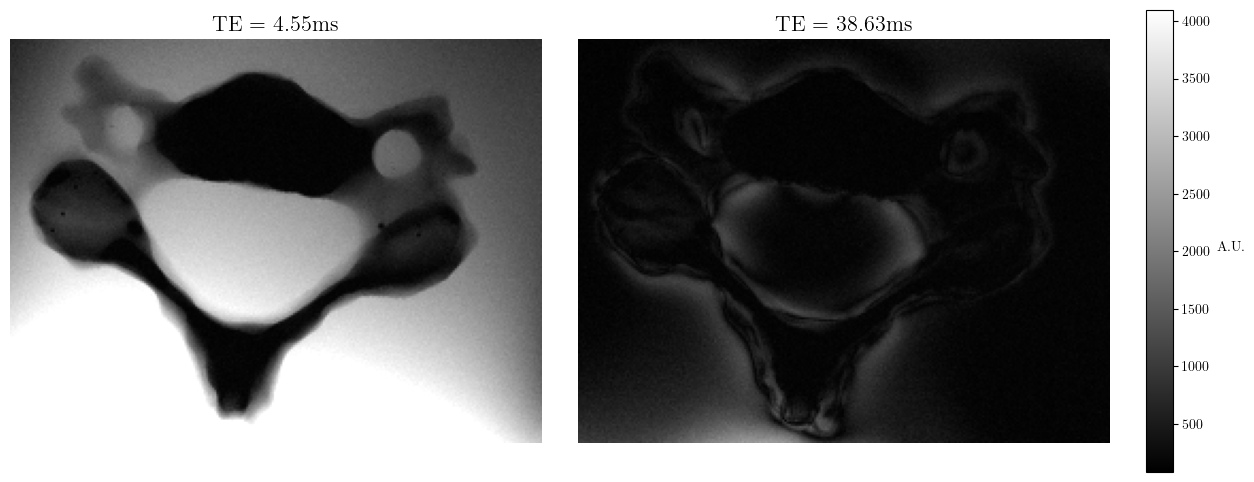

In [21]:
img_idx = 4
plot_white_halo(img_idx)